In [177]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import os as os

#path = "./data/results/"
path = "./results/"

The load_curves function loads the results of multiple algorithms across different environments from .npy files, stores them in a dictionary structure, and processes them to ensure the curves all have the same length.

In [178]:
def load_curves(algorithms, envs, t):
    curves = {alg: {e: [] for e in envs} for alg in algorithms} # create a dictionary 
    for alg in algorithms:
        for e in envs:
            for i in range(0, 100):
                if t == 0: name = f"{path}/{alg}_{e}_{i}.npy"
                if t == 1: name = f"{path}/{alg}_{e}_{i}_s.npy"
                
                if os.path.isfile(name):
                    #print(f"{name} loaded", np.load(name).shape)
                    curves[alg][e].append(list(np.load(name)))
            max_size = -1        
            for i in range(len(curves[alg][e])):
                if len(curves[alg][e][i]) > max_size:
                    max_size = len(curves[alg][e][i])
            for i in range(len(curves[alg][e])):
                while len(curves[alg][e][i]) <= max_size:
                    curves[alg][e][i].append(curves[alg][e][i][-1])

            curves[alg][e] = np.array(curves[alg][e]) if len(curves[alg][e]) else np.array([[]])


    return curves

The smooth function applies a smoothing technique to the loaded data by averaging over a window of neighboring points, creating a more visually appealing curve by reducing fluctuations.

In [179]:
def smooth(data, length=10):
    data = data.copy()
    pad = copy.deepcopy(data[:, -1, None].repeat(length-1, axis=-1)) # padding the data
    pad_data = np.concatenate((data, pad), axis=-1)
    pad = copy.deepcopy(data[:, 0, None].repeat(length-1, axis=-1))  # padding the data
    pad_data = np.concatenate((pad, pad_data), axis=-1)
    
    for i in range(length, len(data[0])+length):
        assert i-length >= 0
        data[:, i-length] = np.mean(pad_data[:, i-length:i+length], axis=-1) # smooth the data with its average
    return data

Plot the results

In [180]:
def plot_results(ENVS, ALGORITHMS, curves, use_median=False):
    """
    Plots the performance curves for different algorithms in various environments.

    Parameters:
    - ENVS: List of environment names.
    - ALGORITHMS: List of algorithm names.
    - curves: Dictionary of data for each algorithm and environment.
    - use_median: Boolean; if True, use median with quartiles; if False, use mean with std deviation.
    """
    
    for k, e in enumerate(ENVS):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.set_title(e)  # Set environment name as the title
        ax.set_xlabel("Steps [1e4]")  # Label for x-axis
        ax.set_ylabel("Success rate" if use_median else "Reward")  # Label for y-axis

        for i, alg in enumerate(ALGORITHMS):
            c = curves[alg][e]  # Get data for the algorithm on this environment
            if c.size == 0:
                print(f"No data for {alg} on {e}. Skipping.")
                continue  # Skip if there's no data
            
            x = np.arange(c.shape[1]) / 2  # X-axis (time or episode count)

            if use_median:
                # Compute median, 1st quartile (25th percentile), and 3rd quartile (75th percentile)
                median = smooth(np.median(c, axis=0, keepdims=True), length=2).squeeze()  # Smooth median
                q1 = smooth(np.percentile(c, 25, axis=0, keepdims=True), length=2).squeeze()  # Smooth 25th percentile
                q3 = smooth(np.percentile(c, 75, axis=0, keepdims=True), length=2).squeeze()  # Smooth 75th percentile
                
                ax.plot(x, median, label=alg, linewidth=4, linestyle='--', color='C' + str(i))  # Plot median curve
                ax.fill_between(x, q1, q3, alpha=0.2, color='C' + str(i))  # Fill between 1st and 3rd quartile

            else:
                # Compute mean and standard deviation
                mu = smooth(c.mean(axis=0, keepdims=True), length=2).squeeze()  # Smooth mean
                sigma = smooth(c.std(axis=0, keepdims=True), length=2).squeeze()  # Smooth std deviation
                
                ax.plot(x, mu, label=alg, linewidth=4, linestyle='--', color='C' + str(i))  # Plot mean curve
                ax.fill_between(x, mu + sigma, mu - sigma, alpha=0.2, color='C' + str(i))  # Fill between std deviation

            ax.set_xticks(np.arange(0, x[-1] + 1, step=5))
            ax.grid(True)  # Add grid
        
        ax.legend()  # Add legend for algorithms
        plt.show()  # Show the plot

In [181]:
# Define environments and algorithms
ENVS = ['MR-env']
ALGORITHMS = ['OurDDPG']

# ENVS = ['MR-env', 'MR-corridor-env']
# ALGORITHMS = ['OurDDPG', 'ExpD3', 'SAC']

Plots the performance curves for each algorithm on each environment.

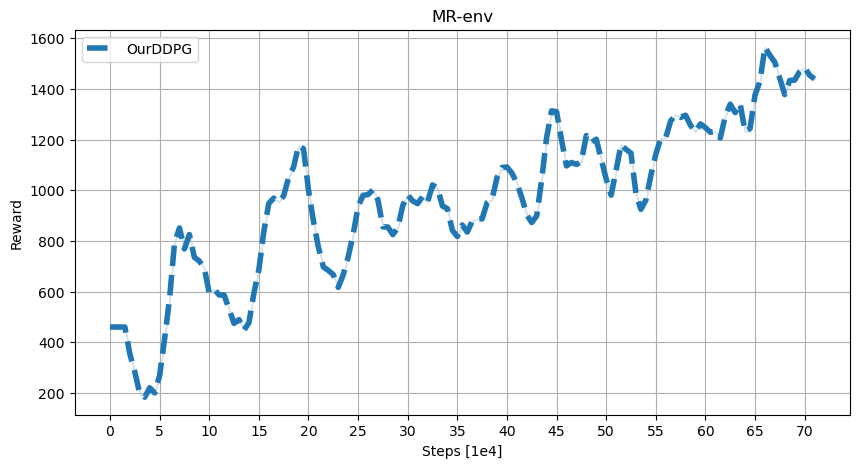

In [182]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 0)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, False)

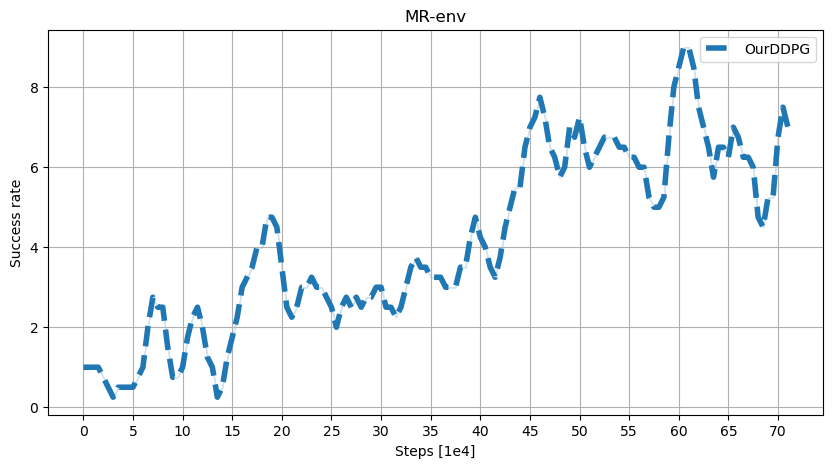

In [183]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 1)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, True)

In [184]:
import glob

def calculate_mean_success_rate(file_pattern):
    # List all files that match the naming pattern
    file_paths = glob.glob(file_pattern)
    
    # Check if any files were found
    if not file_paths:
        print("No files found matching the pattern.")
        return None
    
    # Load each file and store the results in a list
    data = []
    for file_path in file_paths:
        s = np.load(file_path)
        data.append(s)
    
    # Convert the list to a NumPy array and compute the mean
    data = np.array(data)
    mean_success = np.mean(data)
    
    # Display the mean success rate as a percentage
    print(f"Average success rate during training over {len(file_paths)} seeds: {mean_success * 100:.3f} %")

# Example usage:
print("OurDDPG:")
calculate_mean_success_rate("./data/results/OurDDPG_MR-env_*_t.npy")
print("ExpD3:")
calculate_mean_success_rate("./data/results/ExpD3_MR-env_*_t.npy")
print("SAC:")
calculate_mean_success_rate("./results/SAC_MR-env_*_t.npy")

OurDDPG:
No files found matching the pattern.
ExpD3:
No files found matching the pattern.
SAC:
Average success rate during training over 1 seeds: 1.198 %
